In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import randint, uniform


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [ ]:
!pip install items

In [ ]:
import json
import cv2
import items

## IMPORT & EXPLORE

In [ ]:
class KeypointsDataset(Dataset):
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        with open(data_file, "r") as f:
            self.data = json.load(f)

        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = cv2.imread(f"{self.img_dir}/{item['id']}.png")
        h, w = img.shape[:2]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(img)

        kps = np.array(item['kps']).flatten()
        kps = kps.astype(np.float32)

        kps[::2] *= 224.0 / w  # Adjust x coordinates
        kps[1::2] *= 224.0 / h  # Adjust y coordinates

        return img, kps

In [ ]:
!unzip "/content/drive/MyDrive/tennis_assistant/tennis_court_det_dataset.zip" -d "/content/tennis_court_det_dataset"

In [ ]:
court_keypoints_dataset_train = KeypointsDataset(img_dir = "/content/tennis_court_det_dataset/data/images",
                                                data_file = "/content/tennis_court_det_dataset/data/data_train.json" )

court_keypoints_dataset_val = KeypointsDataset(img_dir = "/content/tennis_court_det_dataset/data/images",
                                              data_file = "/content/tennis_court_det_dataset/data/data_val.json" )

In [ ]:
court_keypoints_train_dataloader = DataLoader( court_keypoints_dataset_train, batch_size = 32, drop_last = True )
court_keypoints_val_dataloader = DataLoader( court_keypoints_dataset_val, batch_size = 32, drop_last = True )


In [ ]:
court_keypoints_dataset_train.__getitem__(42)

(tensor([[[-1.6898, -1.3473, -1.6384,  ..., -1.3644, -1.4158, -1.5870],
          [-1.3473, -1.2103, -0.9534,  ..., -1.0048, -1.1418, -1.2959],
          [-1.0219, -1.0733, -1.1760,  ..., -1.3302, -1.3130, -1.4500],
          ...,
          [-1.3302, -0.9363, -0.9192,  ..., -1.1418, -1.1247, -1.2103],
          [-1.0733, -0.6452, -0.8678,  ..., -1.1247, -1.1247, -1.2103],
          [-1.3987, -0.9877, -0.7137,  ..., -1.1418, -1.1418, -1.2274]],
 
         [[-1.5105, -1.1604, -1.5105,  ..., -1.3004, -1.3179, -1.4930],
          [-1.1779, -1.0378, -0.8102,  ..., -0.9153, -1.0378, -1.1954],
          [-0.9328, -0.9853, -1.0903,  ..., -1.2304, -1.1779, -1.3179],
          ...,
          [-1.4930, -0.6527, -0.0399,  ..., -0.1099, -0.1450, -0.3025],
          [-1.2479, -0.6001, -0.1275,  ..., -0.1099, -0.1450, -0.3200],
          [-1.4230, -0.9503, -0.0924,  ..., -0.1275, -0.1450, -0.3200]],
 
         [[-1.2990, -0.9504, -1.2816,  ..., -1.1421, -1.1770, -1.3513],
          [-0.9504, -0.7936,

In [ ]:
len(court_keypoints_dataset_train)

6630

## MODEL BUILD

#### ARCHITECTURE

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.cuda.get_device_properties()

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15095MB, multi_processor_count=40, uuid=eaaaad6f-aa20-9f2a-a9f1-af32c0654bb5, L2_cache_size=4MB)

In [ ]:
efficientnetb4 = models.efficientnet_b4(pretrained = True)

In [ ]:
efficientnetb4

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:

in_features = efficientnetb4.classifier[1].in_features
efficientnetb4.classifier[1] = torch.nn.Linear(in_features, 14 * 2)

In [ ]:
efficientnetb4 = efficientnetb4.to(device)

In [17]:
summary(efficientnetb4, (3,224,224), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]           1,152
      BatchNorm2d-14         [-1, 24, 1

#### TRAINING

In [18]:
optimizer = torch.optim.Adam( efficientnetb4.parameters(), lr=1e-4 )
mse_loss = torch.nn.MSELoss()


train_losses = []
val_losses = []

for epoch in range(100):

    efficientnetb4.train()
    for step, (images, keypoints) in enumerate(court_keypoints_train_dataloader):

        images = images.to(device)
        keypoints = keypoints.to(device) # Moving to GPU

        optimizer.zero_grad() # Flush gradients
        outputs = efficientnetb4(images) # Get output of a model
        loss = mse_loss( outputs, keypoints ) # Coompute loss
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        print(f'Epoch {epoch}, Step {step}, Training Loss: {loss.item():.4f}')


    efficientnetb4.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, keypoints in court_keypoints_val_dataloader:

            images = images.to(device)
            keypoints = keypoints.to(device)
            outputs = efficientnetb4(images)

            val_loss_computed = mse_loss( outputs, keypoints )
            val_loss += val_loss_computed.item()

        avg_val_loss = val_loss / len(court_keypoints_val_dataloader)
        val_losses.append(avg_val_loss)
        print(f'--- Epoch {epoch}, Validation Loss: {avg_val_loss:.4f} ---')






Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 13, Step 202, Training Loss: 11.9131
Epoch 13, Step 203, Training Loss: 29.0943
Epoch 13, Step 204, Training Loss: 18.6394
Epoch 13, Step 205, Training Loss: 11.7950
Epoch 13, Step 206, Training Loss: 10.3426
--- Epoch 13, Validation Loss: 8.4118 ---
Epoch 14, Step 0, Training Loss: 9.5034
Epoch 14, Step 1, Training Loss: 10.4512
Epoch 14, Step 2, Training Loss: 10.9117
Epoch 14, Step 3, Training Loss: 26.1261
Epoch 14, Step 4, Training Loss: 43.6290
Epoch 14, Step 5, Training Loss: 11.0871
Epoch 14, Step 6, Training Loss: 12.3256
Epoch 14, Step 7, Training Loss: 12.7452
Epoch 14, Step 8, Training Loss: 10.8042
Epoch 14, Step 9, Training Loss: 10.6637
Epoch 14, Step 10, Training Loss: 37.6776
Epoch 14, Step 11, Training Loss: 9.5621
Epoch 14, Step 12, Training Loss: 15.6723
Epoch 14, Step 13, Training Loss: 37.3152
Epoch 14, Step 14, Training Loss: 12.3911
Epoch 14, Step 15, Training Loss: 10.1826
Epoch 14, Step 

KeyboardInterrupt: 

In [20]:

import matplotlib.pyplot as plt
import seaborn as sns




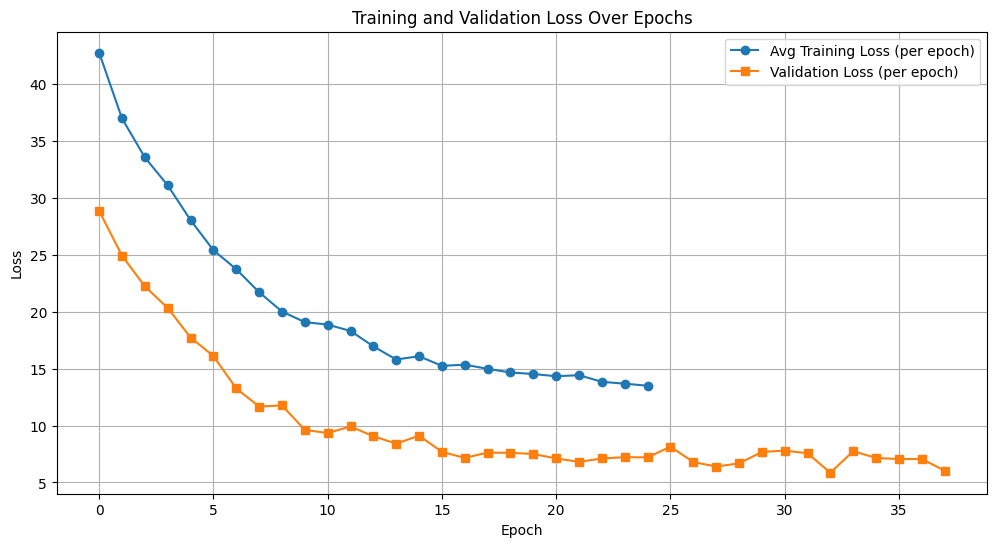

In [21]:
import numpy as np

# Convert step-wise training losses to per-epoch average
steps_per_epoch = len(court_keypoints_train_dataloader)
train_losses_per_epoch = [
    np.mean(train_losses[i * steps_per_epoch: (i + 1) * steps_per_epoch])
    for i in range(25)
]

plt.figure(figsize=(12, 6))
plt.plot(train_losses_per_epoch, label='Avg Training Loss (per epoch)', marker='o')
plt.plot(val_losses, label='Validation Loss (per epoch)', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


#### TESTING

In [22]:
test_image_path = "/content/drive/MyDrive/tennis_assistant/test_image.jpg"

In [23]:
image = cv2.imread(test_image_path)
images = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

In [24]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [28]:
input_tensor = transform(image).unsqueeze(0).to('cpu')  # Add batch dimension

In [29]:
efficientnetb4.eval()
with torch.no_grad():
    pred = efficientnetb4(input_tensor).cpu().numpy().reshape(-1, 2)  # shape: (14, 2)


pred[:, 0] *= w / 224.0  # x coordinates
pred[:, 1] *= h / 224.0  # y coordinates

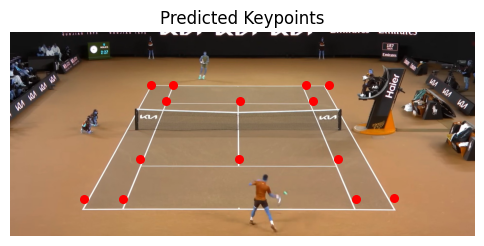

In [30]:
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.scatter(pred[:, 0], pred[:, 1], c='red', s=30)
plt.title('Predicted Keypoints')
plt.axis('off')
plt.show()

In [32]:
# Video path
video_path = "/content/drive/MyDrive/tennis_assistant/tennis_game_sample2.mp4"

# Output video (optional)
output_path = "/content/drive/MyDrive/tennis_assistant/annotated_output.mp4"

# Transformation (same as training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# OpenCV video reader/writer
cap = cv2.VideoCapture(video_path)

# Get video info
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# (Optional) Setup video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Model in eval mode
efficientnetb4.eval()

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    original = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w = original.shape[:2]

    # Preprocess
    img_tensor = transform(original).unsqueeze(0).to('cpu')

    with torch.no_grad():
        pred = efficientnetb4(img_tensor).cpu().numpy().reshape(-1, 2)

    # Scale keypoints to original image
    pred[:, 0] *= w / 224.0
    pred[:, 1] *= h / 224.0

    # Draw keypoints
    for (x, y) in pred.astype(np.int32):
        cv2.circle(frame, (x, y), 4, (0, 0, 255), -1)

    # Write or show
    out.write(frame)  # write to output file
    frame_count += 1

    # Optional: preview in real time (press q to quit)
    cv2.imshow("Keypoints", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Processed {frame_count} frames, saved to {output_path}")

DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow


In [ ]:
device = next(efficientnetb4.parameters()).device
print(f"Model is on: {device}")

Model is on: cuda:0


In [19]:
efficientnetb4 = efficientnetb4.to('cpu')
torch.save(efficientnetb4.state_dict(), "/content/drive/MyDrive/tennis_assistant/efficientnetb4_tennis_court_keypoints.pt")